In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from collections import Counter
import matplotlib.pyplot as plt

## Read in file

In [2]:
FILE_PATH_ROOT = '/home/dharakyu/signaling-bandits/outputs/' \
                '4x4-partial_chunk-2_chain-len-5_run-1_val'
NUM_SHAPES = 4
NUM_COLORS = 4

df = pd.read_pickle(FILE_PATH_ROOT + '.pkl')

## Get labels (utilities)

In [3]:
def convert_df_col_to_np_array(df, col_name):
    """
    Helper function to convert a column of a df to a np array
    """
    list_of_np_arrays = df[col_name].tolist()
    return np.concatenate(list_of_np_arrays, axis=0)

def extract_utilities_from_reward_matrix(stack):
    """
    Extract the utilities from the reward matrices
    """
    all_utilities = []
    for i in range(3200):
        row = stack[i, :]
        matrix = row.reshape(NUM_COLORS * NUM_SHAPES, -1)
        utilities = matrix[:, -2]
        all_utilities.append(utilities)
    return np.array(all_utilities)

In [4]:
reward_matrices = convert_df_col_to_np_array(df=df, col_name='reward_matrix') # (3200, NUM_COLORS*NUM_SHAPES*encoding_len)
utilities = extract_utilities_from_reward_matrix(reward_matrices) # (3200, NUM_COLORS*NUM_SHAPES)

## Get inputs (messages)

In [5]:
message_col_names = [col_name for col_name in df.columns.tolist() if 'message' in col_name]
print(message_col_names)

['message_0', 'message_1', 'message_2', 'message_3', 'message_4']


In [6]:
messages = [convert_df_col_to_np_array(df=df, col_name=col_name) for col_name in message_col_names]
messages = np.array(messages)
messages = np.swapaxes(messages, 0, 1)
messages.shape

(3200, 5, 320)

## Train the model

In [9]:
def get_R_squared(messages, utilities):
    num_agents = messages.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(messages, utilities)
    
    avg_R_squared_for_each_gen = []
    
    # for each generation of agents
    for gen in range(num_agents):
        #print('gen', gen)
        X_train_gen = X_train[:, gen, :]
        X_test_gen = X_test[:, gen, :]

        R_squareds = []
        # for each object in the reward matrix
        for util_idx in range(y_train.shape[1]):
            clf = Ridge().fit(X_train_gen, y_train[:, util_idx])
            pred = clf.predict(X_test_gen)
            R_squared = clf.score(X_test_gen, y_test[:, util_idx])
            R_squareds.append(R_squared)

        avg_R_squared_for_each_gen.append(np.mean(R_squareds))
    return avg_R_squared_for_each_gen

In [10]:
avg_R_squared = get_R_squared(messages, utilities)
for i in range(len(avg_R_squared)):
    print('gen', i, avg_R_squared[i])

gen 0 0.15088617951459538
gen 1 0.18853765252647012
gen 2 0.22825188977066774
gen 3 0.23162863820479973
gen 4 0.24158289371543262


## Permutation test

In [15]:
def permutation_test_R_squared(messages, utilities):
    num_agents = messages.shape[1]
    
    # randomly shuffle the order of the utilities such that they no longer
    # correspond with the messages
    np.random.shuffle(utilities)
    
    X_train, X_test, y_train, y_test = train_test_split(messages, utilities)
    
    avg_R_squared_for_each_gen = []
    
    # for each generation of agents
    for gen in range(num_agents):
        #print('gen', gen)
        X_train_gen = X_train[:, gen, :]
        X_test_gen = X_test[:, gen, :]

        R_squareds = []
        # for each object in the reward matrix
        for util_idx in range(y_train.shape[1]):
            clf = Ridge().fit(X_train_gen, y_train[:, util_idx])
            pred = clf.predict(X_test_gen)
            R_squared = clf.score(X_test_gen, y_test[:, util_idx])
            R_squareds.append(R_squared)

        avg_R_squared_for_each_gen.append(np.mean(R_squareds))
    return avg_R_squared_for_each_gen

In [16]:
avg_R_squared = permutation_test_R_squared(messages, utilities)
for i in range(len(avg_R_squared)):
    print('gen', i, avg_R_squared[i])

gen 0 -0.012355926044217327
gen 1 -0.008914293333003295
gen 2 -0.007868174471435091
gen 3 -0.0038949962149325904
gen 4 -0.005694437609485091


## Do it in a loop, for different experimental conditions

In [38]:
FILE_PATH_ROOT = '/home/dharakyu/signaling-bandits/outputs/' \
                '4x4-partial_chunk-2_chain-len-'
chain_lens = [2, 3, 4, 5]
run_nums = [1, 2, 3, 4, 5]

for chain_len in [5]:
    print('chain length', chain_len)
    R_squared_for_each_gen = []
    
    for run_num in run_nums:
        full_path = FILE_PATH_ROOT + '{chain_len}_run-{run_num}_val.pkl'.format(chain_len=chain_len, run_num=run_num)
        df = pd.read_pickle(full_path)
        reward_matrices = convert_df_col_to_np_array(df=df, col_name='reward_matrix') # (3200, NUM_COLORS*NUM_SHAPES*encoding_len)
        utilities = extract_utilities_from_reward_matrix(reward_matrices) # (3200, NUM_COLORS*NUM_SHAPES)
        message_col_names = [col_name for col_name in df.columns.tolist() if 'message' in col_name]
        messages = [convert_df_col_to_np_array(df=df, col_name=col_name) for col_name in message_col_names]
        messages = np.array(messages)
        messages = np.swapaxes(messages, 0, 1)
        avg_R_squared = get_R_squared(messages, utilities)
        R_squared_for_each_gen.append(avg_R_squared)
        
    R_squared_for_each_gen = np.array(R_squared_for_each_gen)
    gen_means = np.mean(R_squared_for_each_gen, axis=0)
    for i in range(gen_means.shape[0]):
        print('MSE at gen', i, gen_means[i])
        

chain length 5
MSE at gen 0 0.14568858200567722
MSE at gen 1 0.19841148333283432
MSE at gen 2 0.22610944546664308
MSE at gen 3 0.23375392917745766
MSE at gen 4 0.23246954275846238


## Predict the position of the agent, given the message

In [37]:
for chain_len in [5]:
    print('chain length', chain_len)
    accuracy_for_each_run = []
    
    for run_num in run_nums:

        full_path = FILE_PATH_ROOT + '{chain_len}_run-{run_num}_val.pkl'.format(chain_len=chain_len, run_num=run_num)
        df = pd.read_pickle(full_path)
        reward_matrices = convert_df_col_to_np_array(df=df, col_name='reward_matrix') # (3200, NUM_COLORS*NUM_SHAPES*encoding_len)
        utilities = extract_utilities_from_reward_matrix(reward_matrices) # (3200, NUM_COLORS*NUM_SHAPES)
        message_col_names = [col_name for col_name in df.columns.tolist() if 'message' in col_name]
        messages = [convert_df_col_to_np_array(df=df, col_name=col_name) for col_name in message_col_names]
        messages = np.array(messages)
        messages = np.swapaxes(messages, 0, 1)
        
        X = [messages[:, i, :] for i in range(chain_len)]
        X = np.concatenate(X, axis=0)
        print(X.shape)
        
        y = []
        for i in range(chain_len):
            for _ in range(3200):
                y.append(i)
        #print(X[0])
        #print(y[0])
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = LogisticRegression(solver='saga', penalty='l2').fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        print(acc)

chain length 5
(16000, 320)
0.23275
(16000, 320)
0.234
(16000, 320)
0.25325
(16000, 320)
0.23675
(16000, 320)
0.2195


In [35]:
preds = clf.predict(X_train)
print(Counter(preds))
print(Counter(y_train))

print(len(preds))

Counter({0: 7052, 4: 3158, 2: 1418, 3: 372})
Counter({3: 2416, 0: 2414, 4: 2403, 2: 2386, 1: 2381})
12000


## Qualitative analysis of messages for a single reward matrix

The approach: within a single run, find a single reward matrix, and get all the messages associated with it. Show how similar those messages are to one another. Compare across generations - my hypothesis is that the messages should be increasingly similar as generation increases, since there is increasing overlap in what the agents see.

In [39]:
# load in file
file_path = '/home/dharakyu/signaling-bandits/outputs/' \
                '4x4-partial_chunk-2_chain-len-5_run-1_val.pkl'
NUM_SHAPES = 4
NUM_COLORS = 4

df = pd.read_pickle(file_path)

In [40]:
reward_matrices = convert_df_col_to_np_array(df=df, col_name='reward_matrix') # (3200, NUM_COLORS*NUM_SHAPES*encoding_len)
utilities = extract_utilities_from_reward_matrix(reward_matrices) # (3200, NUM_COLORS*NUM_SHAPES)
_, indices = np.unique(utilities, return_inverse=True, axis=0)
indices.shape
# pick the arrangement of utilities that occurs most frequently
c = Counter(list(indices))
most_freq_val, count = c.most_common(1)[0]

# and get the indices where it appears
indices_of_most_freq_val = np.where(indices == most_freq_val)[0]
indices_of_most_freq_val

array([   8,   87,  108, 1025, 1265, 1448, 1493, 1546, 1599, 2010, 2384,
       2542, 2804, 3133])

In [41]:
# get the messages corresponding to those indices
message_col_names = [col_name for col_name in df.columns.tolist() if 'message' in col_name]
print(message_col_names)
messages = [convert_df_col_to_np_array(df=df, col_name=col_name) for col_name in message_col_names]
messages = np.array(messages)
messages = np.swapaxes(messages, 0, 1)
print(messages.shape)

subset_of_messages = messages[indices_of_most_freq_val]
print(subset_of_messages.shape)

['message_0', 'message_1', 'message_2', 'message_3', 'message_4']
(3200, 5, 320)
(14, 5, 320)


In [105]:
# start by counting how many of the messages are the same
all_tokens = []
all_counts = []
for i in range(5):
    print('generation', i)
    tokens_in_gen = []
    unique_messages, counts = np.unique(subset_of_messages[:, i, :], return_counts=True, axis=0)
    for message in unique_messages:
        print(np.where(message == 1)[0])
        tokens_in_gen.append(np.where(message == 1)[0])
    all_counts.append(counts)
    all_tokens.append(np.array(tokens_in_gen))

generation 0
[  1 130 210 242]
[  1 130 168 242]
[  1 114 194 242]
[  1 108 188 242]
[  1 101 187 242]
[  1  88 168 242]
[  1  83 194 242]
generation 1
[  1 159 239 242]
[  1 108 188 242]
generation 2
[  1 108 188 242]
generation 3
[  1 108 188 242]
generation 4
[  1 108 188 242]


In [118]:
for i in range(5):
    print(all_tokens[i])
    print(all_counts[i])

[[  1 130 210 242]
 [  1 130 168 242]
 [  1 114 194 242]
 [  1 108 188 242]
 [  1 101 187 242]
 [  1  88 168 242]
 [  1  83 194 242]]
[1 1 2 7 1 1 1]
[[  1 159 239 242]
 [  1 108 188 242]]
[ 1 13]
[[  1 108 188 242]]
[14]
[[  1 108 188 242]]
[14]
[[  1 108 188 242]]
[14]


In [96]:
all_tokens_seen = []
for gen_tokens in all_tokens:
    exclude_start_and_stop = gen_tokens[:, 1:3]
    uniq = list(np.unique(exclude_start_and_stop))
    all_tokens_seen.extend(uniq)
    
all_unique_tokens, indices = np.unique(all_tokens_seen, return_inverse=True)
print(all_unique_tokens)
print(indices)

[ 83  88 101 108 114 130 159 168 187 188 194 210 239]
[ 0  1  2  3  4  5  7  8  9 10 11  3  6  9 12  3  9  3  9  3  9]


In [73]:
tokens[:, 1:3]
unique_tokens, indices = np.unique(tokens[:, 1:3], return_inverse=True)
print(unique_tokens)
print(indices)

[ 83  88 101 108 114 130 168 187 188 194 210]
[ 5 10  5  6  4  9  3  8  2  7  1  6  0  9]


In [92]:
cmap = plt.colormaps["tab20"]
inner_colors_indices = [np.where(tokens[i, 1] == unique_tokens)[0][0] for i in range(7)]

print(tokens[:, 1])
print(inner_colors_indices)
inner_colors = cmap(indices[inner_colors_indices])

outer_colors_indices = [np.where(tokens[i, 2] == unique_tokens)[0][0] for i in range(7)]

print(tokens[:, 2])
print(outer_colors_indices)
outer_colors = cmap(indices[outer_colors_indices])

[130 130 114 108 101  88  83]
[5, 5, 4, 3, 2, 1, 0]
[210 168 194 188 187 168 194]
[10, 6, 9, 8, 7, 6, 9]


In [121]:
def get_colors_from_colormap(unique_tokens, indices, gen_tokens, inner):
    cmap = plt.colormaps["tab20"]
    if inner: 
        string_index = 1
    else:
        string_index = 2
    
    num_unique_messages = gen_tokens.shape[0]
    print(np.where(tokens[i, string_index] == unique_tokens)[0][0])
    colors_indices = [np.where(gen_tokens[i, string_index] == unique_tokens)[0][0] for i in range(num_unique_messages)]
    return cmap(indices[colors_indices])

5
10
5
6
4
9
3
8
2
7


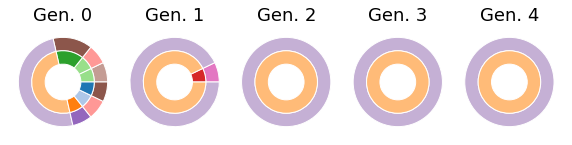

In [138]:
fig, axes = plt.subplots(1, 5, figsize=(10, 10))
size = 0.3
for i, ax in enumerate(axes):
    gen_tokens = all_tokens[i]
    counts = all_counts[i]
    
    inner_colors = get_colors_from_colormap(unique_tokens, indices, gen_tokens, inner=True)
    #print(inner_colors)
    outer_colors = get_colors_from_colormap(unique_tokens, indices, gen_tokens, inner=False)
    ax.pie(counts, radius=1, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'))
    ax.pie(counts, radius=1-size, colors=inner_colors,
           wedgeprops=dict(width=size, edgecolor='w'))
    #ax.set(aspect="equal", title='Gen. ' + str(i))
    ax.set_title('Gen. ' + str(i), fontsize=18)
#plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
for i in range(5):
    print(messages[:, i, :].shape)
    unique_messages_across_iteration = np.unique(messages[:, i, :], axis=0)
    print(len(unique_messages_across_iteration))